## CANTILEVER RETAINING WALL (RW-2)

Minimum contact pressure qmin:  0.00 kPa
Maximum contact pressure qmax:  148.49 kPa
Actual soil bearing:            125.00 kPa
Soil bearing check:             Soil bearing pressure is NOT acceptable.
Tension check:                  Tension occurs (one or more pressures are zero or negative).
FS against overturning:         4.36 → The wall is stable against overturning
FS against sliding:             2.02 → The wall is stable against sliding


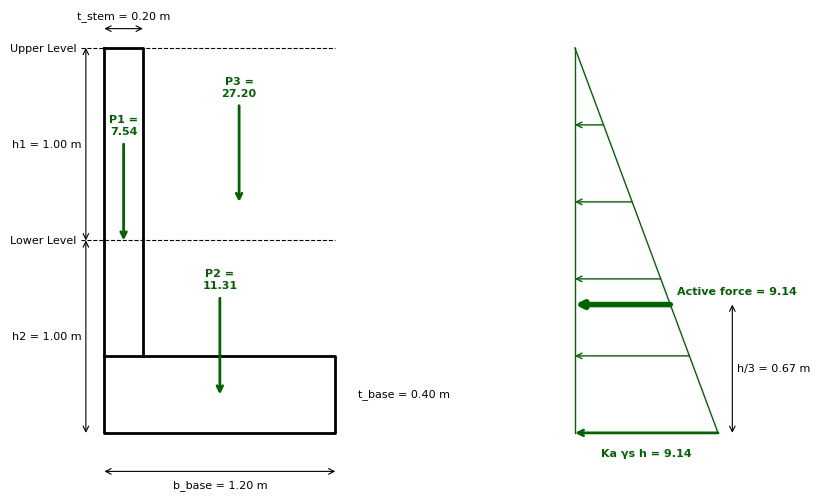

In [73]:
import math
import numpy as np
import matplotlib.pyplot as plt

def cantilever_retaining_wall(soil_unit_weight,soil_friction_angle,soil_concrete_friction_coefficient,soil_bearing,h1, h2,t_stem, t_base,b_base, b_heel):

    def vertical_loads(soil_unit_weight,concrete_unit_weight,h1, h2,t_stem, t_base,b_base, b_heel):
        """Compute vertical loads and restoring moment components."""
        total_height = h1 + h2

        # --- Vertical loads (Restoring Moment) ---
        p1 = concrete_unit_weight * t_stem * (total_height - t_base)         # stem weight
        p2 = concrete_unit_weight * t_base * b_base                          # base slab weight
        p3 = soil_unit_weight * (total_height - t_base) * (b_base - t_stem)  # backfill on heel
        total_vertical_load = p1 + p2 + p3

        m1 = p1 * (t_stem / 2)
        m2 = p2 * (b_base / 2)
        m3 = p3 * (b_base - b_heel / 2)
        total_restoring_moment = m1 + m2 + m3

        return p1, p2, p3, total_vertical_load, total_restoring_moment

    def lateral_loads(soil_unit_weight,soil_friction_angle,total_height):
        """Compute Ka, forces, and overturning moment."""
        phi_rad = math.radians(soil_friction_angle)
        sin_phi = math.sin(phi_rad)
        ka = (1.0 - sin_phi) / (1.0 + sin_phi)

        max_horizontal_pressure = ka * soil_unit_weight * total_height
        active_force = ka * soil_unit_weight * (total_height ** 2) / 2
        overturning_moment = active_force * (total_height / 3)

        return ka, max_horizontal_pressure, active_force, overturning_moment

# TODO double check the formula
    def calc_pressure(net_moment,b_base,total_vertical_load):
        """Compute qmin and qmax based on eccentricity."""
        eccentricity = net_moment / total_vertical_load
        e_abs = abs(eccentricity)
        footing_area = b_base * 1.0
        q_average = total_vertical_load / footing_area

        if e_abs <= b_base / 6:  # full contact
            qmax = q_average * (1 + 6 * eccentricity / b_base)
            qmin = q_average * (1 - 6 * eccentricity / b_base)
            if eccentricity == 0:
                qmax = qmin = q_average
            if e_abs == b_base / 6:
                qmin = 0.0

        elif e_abs < b_base / 2:  # partial contact
            b_eff = b_base - 2 * e_abs
            a_eff = b_eff * 1.0
            qmin = 0.0
            qmax = total_vertical_load / a_eff

        else:  # overturning (unstable)
            raise ValueError("The resultant lies outside the middle third of the base; the footing is unstable.")

        return qmin, qmax

    def evaluate_pressures(max_pressure, min_pressure, soil_bearing):
        if max_pressure < soil_bearing and min_pressure < soil_bearing:
            bearing_result = "Soil bearing pressure is acceptable."
        else:
            bearing_result = "Soil bearing pressure is NOT acceptable."

        if max_pressure > 0 and min_pressure > 0:
            tension_result = "No tension (both pressures are positive)."
        else:
            tension_result = "Tension occurs (one or more pressures are zero or negative)."

        return bearing_result, tension_result

    def evaluate_fos(fs_overturning, fs_sliding):
        if fs_overturning < 1.5:
            fs_overturning_result = "The wall is not stable against overturning"
        else:
            fs_overturning_result = "The wall is stable against overturning"

        if fs_sliding < 1.5:
            fs_sliding_result = "The wall is not stable against sliding"
        else:
            fs_sliding_result = "The wall is stable against sliding"

        return fs_overturning_result, fs_sliding_result

    # --- Run sub‐calculations ---
    p1, p2, p3, total_vertical_load, total_restoring_moment = vertical_loads(soil_unit_weight, concrete_unit_weight, h1, h2, t_stem, t_base, b_base, b_heel)
    
    total_height = h1 + h2

    ka, max_horizontal_pressure, active_force, overturning_moment = lateral_loads(soil_unit_weight, soil_friction_angle, total_height)
    
    net_moment = total_restoring_moment - overturning_moment

    qmin, qmax = calc_pressure(net_moment, b_base, total_vertical_load)
    
    min_pressure, max_pressure = qmin, qmax

    soil_bearing_check = evaluate_pressures(max_pressure, min_pressure, soil_bearing)

    fs_overturning = total_restoring_moment / overturning_moment
    
    fs_sliding = (soil_concrete_friction_coefficient * total_vertical_load) / active_force
    
    fs_checking = evaluate_fos(fs_overturning, fs_sliding)

    # --- Plot function (unchanged symbols) ---
    def plot_retaining_wall_and_pressure(h1, h2, t_stem, t_base, b_base,
                                         p1, p2, p3, active_force, max_horizontal_pressure):
        # geometry
        y_top   =  h1
        y_gl    =  0.0
        y_iface = -(h2 - t_base)
        y_bot   = -h2
        span    = h1 + h2
        yH      = y_bot + span/3
        h3_val  = span/3

        # make figure
        fig, (ax, ax2) = plt.subplots(
            1, 2, figsize=(12,6),
            gridspec_kw={'width_ratios':[3,1], 'wspace':0},
            sharey=True
        )

        # ----- LEFT: retaining wall -----
        verts = [
            (0.0, y_top), (t_stem, y_top),
            (t_stem, y_iface), (b_base, y_iface),
            (b_base, y_bot), (0.0, y_bot),
            (0.0, y_gl),    (0.0, y_top),
        ]
        xs, ys = zip(*verts)
        ax.plot(xs, ys, color='black', linewidth=2)
        ax.plot([0, t_stem], [y_iface, y_iface], color='black', linewidth=2)

        # dashed levels
        ax.hlines([y_top, y_gl], xmin=-0.1*b_base, xmax=b_base,
                linestyles='--', linewidth=0.8, color='black')
        ax.text(-0.12*b_base, y_top,  'Upper Level', ha='right', va='center', fontsize=8)
        ax.text(-0.12*b_base, y_gl,   'Lower Level', ha='right', va='center', fontsize=8)

        # t_stem dim
        off_ts = 0.05*span
        ay_ts  = y_top + off_ts
        ax.annotate('', xy=(0, ay_ts), xytext=(t_stem, ay_ts),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(t_stem/2, ay_ts+0.02*span, f't_stem = {t_stem:.2f} m',
                ha='center', va='bottom', fontsize=8)

        # h1 & h2 dims
        x_dim = -0.08*b_base
        ax.annotate('', xy=(x_dim, y_top), xytext=(x_dim, y_gl),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(x_dim-0.02*b_base, (y_top+y_gl)/2, f'h1 = {h1:.2f} m',
                ha='right', va='center', fontsize=8)

        ax.annotate('', xy=(x_dim, y_gl), xytext=(x_dim, y_bot),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(x_dim-0.02*b_base, (y_gl+y_bot)/2, f'h2 = {h2:.2f} m',
                ha='right', va='center', fontsize=8)

        # b_base dim
        yb = y_bot - 0.1*span
        ax.annotate('', xy=(0, yb), xytext=(b_base, yb),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(b_base/2, yb-0.02*span, f'b_base = {b_base:.2f} m',
                ha='center', va='top', fontsize=8)

        # t_base dim
        xdr = b_base + 0.08*b_base
        ax.annotate('', xy=(xdr, y_iface), xytext=(xdr, y_bot),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(xdr+0.02*b_base, (y_iface+y_bot)/2, f't_base = {t_base:.2f} m',
                ha='left', va='center', fontsize=8)

        # P‐loads
        dark = '#006400'
        arrow_len = 0.25*span
        for label, x, y, val in (
            ('P1 =', t_stem/2, (y_top+y_bot)/2, p1),
            ('P2 =', b_base/2, (y_iface+y_bot)/2, p2),
            ('P3 =', (t_stem+b_base)/2, (y_top+y_iface)/2, p3),
        ):
            tail = (x, y+arrow_len)
            tip  = (x, y)
            ax.annotate('', xy=tip, xytext=tail,
                        arrowprops=dict(arrowstyle='->', color=dark, lw=2, shrinkA=0, shrinkB=0))
            ax.text(tail[0], tail[1]+0.02*span,
                    f'{label}\n{val:.2f}', color=dark,
                    fontsize=8, fontweight='bold',
                    ha='center', va='bottom')

        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_ylim(y_bot-0.1*span, y_top+0.1*span)


        # ----- RIGHT: pressure triangle -----
        base_w = 0.4 * span
        ax2.plot([0,0],       [y_top, y_bot], color=dark, lw=1)
        ax2.plot([0, base_w],[y_top, y_bot], color=dark, lw=1)

        def x_at(y): return base_w*(y_top-y)/span

        # thin arrows at 20%,40%,60%,80%
        for frac in (0.2, 0.4, 0.6, 0.8):
            yi = y_bot + frac*span
            ax2.annotate('', xy=(0, yi), xytext=(x_at(yi), yi),
                        arrowprops=dict(arrowstyle='->', color=dark, lw=1, shrinkA=0, shrinkB=0))

        # bottom arrow (max horizontal pressure)
        ax2.annotate('', xy=(0, y_bot), xytext=(x_at(y_bot), y_bot),
                    arrowprops=dict(arrowstyle='->', color=dark, lw=2, shrinkA=0, shrinkB=0))
        ax2.text(base_w/2, y_bot - 0.04*span,
                f'Ka γs h = {max_horizontal_pressure:.2f}', color=dark,
                fontsize=8, fontweight='bold', ha='center', va='top')

        # thick arrow at h/3 (active force)
        ax2.annotate('', xy=(0, yH), xytext=(x_at(yH), yH),
                    arrowprops=dict(arrowstyle='->', color=dark, lw=4, shrinkA=0, shrinkB=0))
        ax2.text(x_at(yH)+0.02*span, yH+0.02*span,
                f'Active force = {active_force:.2f}', color=dark,
                fontsize=8, fontweight='bold', ha='left', va='bottom')

        # dimension h/3
        xdim = base_w + 0.1*base_w
        ax2.annotate('', xy=(xdim, y_bot), xytext=(xdim, yH),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8,
                                    color='black', shrinkA=0, shrinkB=0))
        ax2.text(xdim+0.02*b_base, (y_bot+yH)/2,
                f'h/3 = {h3_val:.2f} m', color='black',
                fontsize=8, ha='left', va='center')

        ax2.set_aspect('auto')
        ax2.axis('off')
        ax2.set_ylim(y_bot-0.1*span, y_top+0.1*span)
        ax2.set_xlim(-0.05*span, base_w+0.2*span)

        plt.show()

    # --- Print results ---
    print(f"Minimum contact pressure qmin:  {min_pressure:.2f} kPa")
    print(f"Maximum contact pressure qmax:  {max_pressure:.2f} kPa")
    print(f"Actual soil bearing:            {soil_bearing:.2f} kPa")
    print(f"Soil bearing check:             {soil_bearing_check[0]}")
    print(f"Tension check:                  {soil_bearing_check[1]}")
    print(f"FS against overturning:         {fs_overturning:.2f} → {fs_checking[0]}")
    print(f"FS against sliding:             {fs_sliding:.2f} → {fs_checking[1]}")

    # --- Plot retaining wall ---
    plot_retaining_wall_and_pressure(h1, h2, t_stem, t_base, b_base,p1, p2, p3, active_force, max_horizontal_pressure)

if __name__ == "__main__":
    # Soil and Concrete Data
    soil_unit_weight = 17                    # kN/m^3
    soil_friction_angle = 35.2               # degrees
    soil_concrete_friction_coefficient = 0.4 # TODO check the value
    soil_bearing = 125                       # kPa
    concrete_unit_weight = 23.56             # kN/m^3

    # Geometry
    h1 = 1.0
    h2 = 1.0
    t_stem = 0.20
    t_base = 0.40
    b_base = 1.20
    b_heel = b_base - t_stem

    cantilever_retaining_wall(soil_unit_weight,soil_friction_angle,soil_concrete_friction_coefficient,soil_bearing,h1, h2,t_stem, t_base,b_base, b_heel)

## PLAIN RETAINING WALL (RW-1)

Minimum contact pressure qmin:  0.00 kPa
Maximum contact pressure qmax:  75.22 kPa
Actual soil bearing:            134.00 kPa
Soil bearing check:             Soil bearing pressure is acceptable.
Tension check:                  Tension occurs (one or more pressures are zero or negative).
FS against overturning:         2.22 → The wall is stable against overturning
FS against sliding:             1.13 → The wall is not stable against sliding


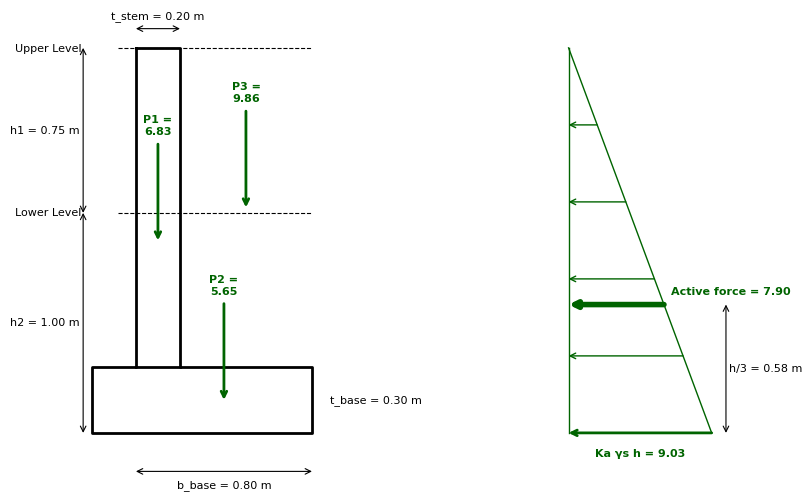

In [90]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plain_retaining_wall(soil_unit_weight,soil_friction_angle,soil_concrete_friction_coefficient,soil_bearing,h1, h2,t_stem, t_base,b_base, b_heel, b_toe):

    def vertical_loads(soil_unit_weight,concrete_unit_weight,h1, h2,t_stem, t_base,b_base, b_heel, b_toe):
        """Compute vertical loads and restoring moment components."""
        total_height = h1 + h2

        # --- Vertical loads (Restoring Moment) ---
        p1 = concrete_unit_weight * t_stem * (total_height - t_base)         # stem weight
        p2 = concrete_unit_weight * t_base * b_base                          # base slab weight
        p3 = soil_unit_weight * (total_height - t_base) * (b_heel)           # backfill on heel
        total_vertical_load = p1 + p2 + p3

        m1 = p1 * (b_toe + t_stem / 2)
        m2 = p2 * (b_base / 2)
        m3 = p3 * (b_base - b_heel / 2)
        total_restoring_moment = m1 + m2 + m3

        return p1, p2, p3, total_vertical_load, total_restoring_moment

    def lateral_loads(soil_unit_weight,soil_friction_angle,total_height):
        """Compute Ka, forces, and overturning moment."""
        phi_rad = math.radians(soil_friction_angle)
        sin_phi = math.sin(phi_rad)
        ka = (1.0 - sin_phi) / (1.0 + sin_phi)

        max_horizontal_pressure = ka * soil_unit_weight * total_height
        active_force = ka * soil_unit_weight * math.pow(total_height, 2) / 2
        overturning_moment = active_force * (total_height / 3)

        return ka, max_horizontal_pressure, active_force, overturning_moment

# TODO double check the formula
    def calc_pressure(net_moment,b_base,total_vertical_load):
        """Compute qmin and qmax based on eccentricity."""
        eccentricity = net_moment / total_vertical_load
        e_abs = abs(eccentricity)
        footing_area = b_base * 1.0
        q_average = total_vertical_load / footing_area

        if e_abs <= b_base / 6:  # full contact
            qmax = q_average * (1 + 6 * eccentricity / b_base)
            qmin = q_average * (1 - 6 * eccentricity / b_base)
            if eccentricity == 0:
                qmax = qmin = q_average
            if e_abs == b_base / 6:
                qmin = 0.0

        elif e_abs < b_base / 2:  # partial contact
            b_eff = b_base - 2 * e_abs
            a_eff = b_eff * 1.0
            qmin = 0.0
            qmax = total_vertical_load / a_eff

        else:  # overturning (unstable)
            raise ValueError("The resultant lies outside the middle third of the base; the footing is unstable.")

        return qmin, qmax

    def evaluate_pressures(max_pressure, min_pressure, soil_bearing):
        if max_pressure < soil_bearing and min_pressure < soil_bearing:
            bearing_result = "Soil bearing pressure is acceptable."
        else:
            bearing_result = "Soil bearing pressure is NOT acceptable."

        if max_pressure > 0 and min_pressure > 0:
            tension_result = "No tension (both pressures are positive)."
        else:
            tension_result = "Tension occurs (one or more pressures are zero or negative)."

        return bearing_result, tension_result

    def evaluate_fos(fs_overturning, fs_sliding):
        if fs_overturning < 1.5:
            fs_overturning_result = "The wall is not stable against overturning"
        else:
            fs_overturning_result = "The wall is stable against overturning"

        if fs_sliding < 1.5:
            fs_sliding_result = "The wall is not stable against sliding"
        else:
            fs_sliding_result = "The wall is stable against sliding"

        return fs_overturning_result, fs_sliding_result

    # --- Run sub‐calculations ---
    p1, p2, p3, total_vertical_load, total_restoring_moment = vertical_loads(soil_unit_weight, concrete_unit_weight, h1, h2, t_stem, t_base, b_base, b_heel, b_toe)
    
    total_height = h1 + h2

    ka, max_horizontal_pressure, active_force, overturning_moment = lateral_loads(soil_unit_weight, soil_friction_angle, total_height)
    
    net_moment = total_restoring_moment - overturning_moment

    qmin, qmax = calc_pressure(net_moment, b_base, total_vertical_load)
    
    min_pressure, max_pressure = qmin, qmax

    soil_bearing_check = evaluate_pressures(max_pressure, min_pressure, soil_bearing)

    fs_overturning = total_restoring_moment / overturning_moment
    
    fs_sliding = (soil_concrete_friction_coefficient * total_vertical_load) / active_force
    
    fs_checking = evaluate_fos(fs_overturning, fs_sliding)

    # --- Plot function (unchanged symbols) ---
    def plot_retaining_wall_and_pressure(h1, h2, t_stem, t_base, b_base, b_toe, p1, p2, p3, active_force, max_horizontal_pressure):
        # geometry
        y_top   =  h1
        y_gl    =  0.0
        y_iface = -(h2 - t_base)
        y_bot   = -h2
        span    = h1 + h2
        yH      = y_bot + span/3
        h3_val  = span/3

        # make figure
        fig, (ax, ax2) = plt.subplots(
            1, 2, figsize=(12,6),
            gridspec_kw={'width_ratios':[3,1], 'wspace':0},
            sharey=True)

        # ----- LEFT: retaining wall -----
        verts = [
        # Stem, upper
        (0.0,    y_top),
        (t_stem, y_top),

        # Stem‐to‐base interface
        (t_stem, y_iface),
        (b_base, y_iface),

        # Entire base slab
        (b_base, y_bot),
        (-b_toe, y_bot),      # ← extend left

        # up to the back of stem again
        (-b_toe, y_iface),    # ← tie back under interface
        (0.0,    y_iface),

        # close back up
        (0.0,    y_top),
        ]

        xs, ys = zip(*verts)
        ax.plot(xs, ys, color='black', linewidth=2)
        ax.plot([0, t_stem], [y_iface, y_iface], color='black', linewidth=2)

        # dashed levels
        margin = 0.06*b_base
        level_x = -b_toe - margin
        ax.hlines([y_top, y_gl], xmin=-0.1*b_base, xmax=b_base,
                linestyles='--', linewidth=0.8, color='black')
        ax.text(level_x, y_top,  'Upper Level', ha='right', va='center', fontsize=8)
        ax.text(level_x, y_gl,   'Lower Level', ha='right', va='center', fontsize=8)

        # t_stem dim
        off_ts = 0.05*span
        ay_ts  = y_top + off_ts
        ax.annotate('', xy=(0, ay_ts), xytext=(t_stem, ay_ts),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(t_stem/2, ay_ts+0.02*span, f't_stem = {t_stem:.2f} m',
                ha='center', va='bottom', fontsize=8)

        # h1 & h2 dims
        margin = 0.05*b_base
        x_dim  = -b_toe - margin

        ax.annotate('', xy=(x_dim, y_top), xytext=(x_dim, y_gl),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(x_dim-0.02*b_base, (y_top+y_gl)/2, f'h1 = {h1:.2f} m',
                ha='right', va='center', fontsize=8)

        ax.annotate('', xy=(x_dim, y_gl), xytext=(x_dim, y_bot),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(x_dim-0.02*b_base, (y_gl+y_bot)/2, f'h2 = {h2:.2f} m',
                ha='right', va='center', fontsize=8)

        # b_base dim
        yb = y_bot - 0.1*span
        ax.annotate('', xy=(0, yb), xytext=(b_base, yb),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(b_base/2, yb-0.02*span, f'b_base = {b_base:.2f} m',
                ha='center', va='top', fontsize=8)

        # t_base dim
        xdr = b_base + 0.08*b_base
        ax.annotate('', xy=(xdr, y_iface), xytext=(xdr, y_bot),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8, color='black', shrinkA=0, shrinkB=0))
        ax.text(xdr+0.02*b_base, (y_iface+y_bot)/2, f't_base = {t_base:.2f} m',
                ha='left', va='center', fontsize=8)

        # P‐loads
        dark = '#006400'
        arrow_len = 0.25*span
        for label, x, y, val in (
            ('P1 =', t_stem/2, (y_top+y_bot)/2, p1),
            ('P2 =', b_base/2, (y_iface+y_bot)/2, p2),
            ('P3 =', (t_stem+b_base)/2, (y_top+y_iface)/2, p3),
        ):
            tail = (x, y+arrow_len)
            tip  = (x, y)
            ax.annotate('', xy=tip, xytext=tail,
                        arrowprops=dict(arrowstyle='->', color=dark, lw=2, shrinkA=0, shrinkB=0))
            ax.text(tail[0], tail[1]+0.02*span,
                    f'{label}\n{val:.2f}', color=dark,
                    fontsize=8, fontweight='bold',
                    ha='center', va='bottom')

        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_ylim(y_bot-0.1*span, y_top+0.1*span)


        # ----- RIGHT: pressure triangle -----
        base_w = 0.4 * span
        ax2.plot([0,0],       [y_top, y_bot], color=dark, lw=1)
        ax2.plot([0, base_w],[y_top, y_bot], color=dark, lw=1)

        def x_at(y): return base_w*(y_top-y)/span

        # thin arrows at 20%,40%,60%,80%
        for frac in (0.2, 0.4, 0.6, 0.8):
            yi = y_bot + frac*span
            ax2.annotate('', xy=(0, yi), xytext=(x_at(yi), yi),
                        arrowprops=dict(arrowstyle='->', color=dark, lw=1, shrinkA=0, shrinkB=0))

        # bottom arrow (max horizontal pressure)
        ax2.annotate('', xy=(0, y_bot), xytext=(x_at(y_bot), y_bot),
                    arrowprops=dict(arrowstyle='->', color=dark, lw=2, shrinkA=0, shrinkB=0))
        ax2.text(base_w/2, y_bot - 0.04*span,
                f'Ka γs h = {max_horizontal_pressure:.2f}', color=dark,
                fontsize=8, fontweight='bold', ha='center', va='top')

        # thick arrow at h/3 (active force)
        ax2.annotate('', xy=(0, yH), xytext=(x_at(yH), yH),
                    arrowprops=dict(arrowstyle='->', color=dark, lw=4, shrinkA=0, shrinkB=0))
        ax2.text(x_at(yH)+0.02*span, yH+0.02*span,
                f'Active force = {active_force:.2f}', color=dark,
                fontsize=8, fontweight='bold', ha='left', va='bottom')

        # dimension h/3
        xdim = base_w + 0.1*base_w
        ax2.annotate('', xy=(xdim, y_bot), xytext=(xdim, yH),
                    arrowprops=dict(arrowstyle='<->', linewidth=0.8,
                                    color='black', shrinkA=0, shrinkB=0))
        ax2.text(xdim+0.02*b_base, (y_bot+yH)/2,
                f'h/3 = {h3_val:.2f} m', color='black',
                fontsize=8, ha='left', va='center')

        ax2.set_aspect('auto')
        ax2.axis('off')
        ax2.set_ylim(y_bot-0.1*span, y_top+0.1*span)
        ax2.set_xlim(-0.05*span, base_w+0.2*span)

        plt.show()

    # --- Print results ---
    print(f"Minimum contact pressure qmin:  {min_pressure:.2f} kPa")
    print(f"Maximum contact pressure qmax:  {max_pressure:.2f} kPa")
    print(f"Actual soil bearing:            {soil_bearing:.2f} kPa")
    print(f"Soil bearing check:             {soil_bearing_check[0]}")
    print(f"Tension check:                  {soil_bearing_check[1]}")
    print(f"FS against overturning:         {fs_overturning:.2f} → {fs_checking[0]}")
    print(f"FS against sliding:             {fs_sliding:.2f} → {fs_checking[1]}")

    # --- Plot retaining wall ---
    plot_retaining_wall_and_pressure(h1, h2, t_stem, t_base, b_base,b_toe, p1, p2, p3, active_force, max_horizontal_pressure)

if __name__ == "__main__":
    # Soil and Concrete Data
    soil_unit_weight = 17                    # kN/m^3
    soil_friction_angle = 32.3               # degrees
    soil_concrete_friction_coefficient = 0.4 # TODO check the value
    soil_bearing = 134                       # kPa
    concrete_unit_weight = 23.56             # kN/m^3

    # Geometry
    h1 = .75        #m
    h2 = 1.0        #m
    t_stem = 0.20   #m 0.07h to 0.12h
    t_base = 0.30   #m 0.07h to 0.1h; min: 12in
    b_base = 0.80   #m
    b_toe = 0.20    #m b/4 to b/3, lower soil height
    b_heel = b_base - b_toe - t_stem

    plain_retaining_wall(soil_unit_weight,soil_friction_angle,soil_concrete_friction_coefficient,soil_bearing,h1, h2,t_stem, t_base,b_base, b_heel,b_toe)